# 『ゼロから作るDeep Learning』6章前半（最適化）

6章「学習に関するテクニック」の前半、パラメータの更新手法最適化と重みの初期値の最適化について扱う。

## Setup

ライブラリのインポート、既存関数のパッチ当て、共通関数の定義を行う。

In [54]:
# 初期インポート
import os
import sys
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from collections import OrderedDict

# PythonDLのソースコードをgit cloneしたパスを読み込み先パスに指定
# https://github.com/oreilly-japan/deep-learning-from-scratch
sys.path.append('C:/repos/deep-learning-from-scratch') 
sys.path.append('.') 

from common.optimizer import *

In [2]:
# urllib.requestのプロキシ対応

import urllib.request
proxy = urllib.request.ProxyHandler({'http': '127.0.0.1:3128'})
opener = urllib.request.build_opener(proxy)
urllib.request.install_opener(opener)

In [3]:
# 3次元ワイヤーフレームの描画関数を定義
def plot_3d(x_range, y_range, z_function):
    X, Y = np.meshgrid(x_range, y_range)

    Z = z_function(X,Y)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_wireframe(X,Y,Z)

    plt.show()
    
# plot_3d(np.arange(-10, 10, 0.5), np.arange(-10, 10, 0.5), lambda x, y: x**2 + y**2)

In [4]:
# 等高線図の描画関数を定義
class ContourPlotter:
    def __init__(self):
        self.init_pos = (-7.0, 2.0) # 探索開始位置
        self.steps = 30 # 探索経路の移動数
        self.f = lambda x, y: x**2 / 20.0 + y**2 # 探索対象の関数
        self.df = lambda x, y: (x / 10.0, 2.0*y) # fの微分

    def plot_contourmap(self, optimizer, title):
        params = {}
        params['x'], params['y'] = self.init_pos[0], self.init_pos[1]
        grads = {}
        grads['x'], grads['y'] = 0, 0

        x_history = []
        y_history = []
        params['x'], params['y'] = self.init_pos[0], self.init_pos[1]

        for i in range(self.steps):
            x_history.append(params['x'])
            y_history.append(params['y'])

            grads['x'], grads['y'] = self.df(params['x'], params['y'])
            optimizer.update(params, grads)

        x = np.arange(-10, 10, 0.01)
        y = np.arange(-5, 5, 0.01)

        X, Y = np.meshgrid(x, y) 
        Z = self.f(X, Y)

        # for simple contour line  
        mask = Z > 7
        Z[mask] = 0

        # plot
        plt.plot(x_history, y_history, 'o-', color="red")
        plt.contour(X, Y, Z)
        plt.ylim(-10, 10)
        plt.xlim(-10, 10)
        plt.plot(0, 0, '+')
        plt.title(title)
        plt.xlabel("x")
        plt.ylabel("y")

        plt.show()
    
# ContourPlotter().plot_contourmap(SGD(lr=0.95))

## 6.1.1　冒険家の話

最適化とは、冒険家が目隠しをしながら靴底に感じる地面の傾斜だけを頼りに最も低い谷底を探しに行くようなもの、という話

## 6.1.2　SGD

勾配方向へある一定の距離だけ進むという単純な方法。

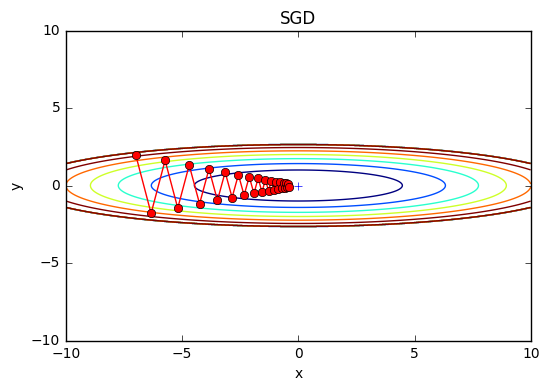

In [5]:
class SGD:
    """確率的勾配降下法（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr # 学習係数（learning rate）をインスタンス変数に初期設定
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

# 等高線図上に描画
ContourPlotter().plot_contourmap(SGD(lr=0.95), "SGD")

## 6.1.3　SGDの欠点

SGDは、傾斜が急な方向に進むため伸びた楕円のような形の関数だとジグザグで非効率な動きをしてしまう欠点がある。

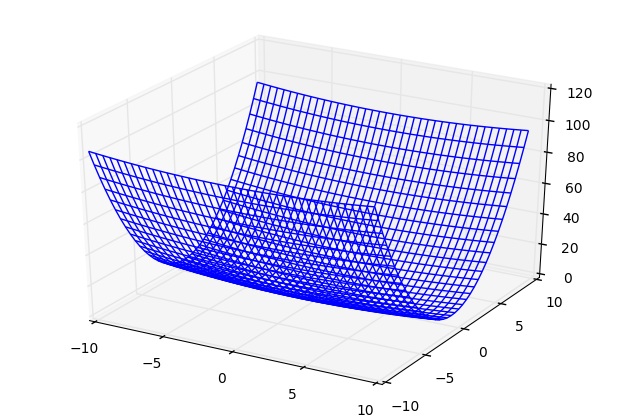

In [6]:
# 図6-1（式6.2）のグラフ描画
plot_3d(np.arange(-10, 10, 0.5), np.arange(-10, 10, 0.5), lambda x, y: x**2 / 20 + y**2)

## 6.1.4　Momentum

ボールが地面を転がるように、物体が勾配方向に力を受け、その力によって物体の速度が加算される物理法則を適用した手法。

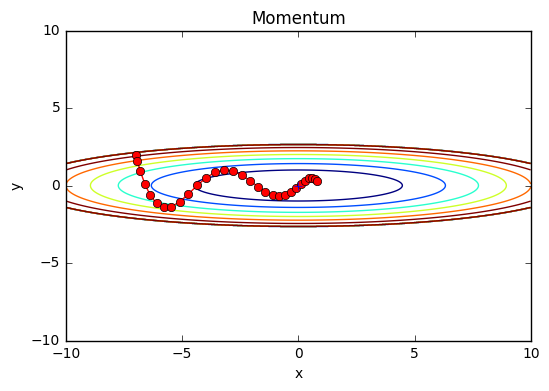

In [7]:
class Momentum:
    """Momentum SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            # self.v = {'x': array(0.0), 'y': array(0.0)}

        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] # 地面の摩擦や空気抵抗（momentum）と物体の速度(v)
            params[key] += self.v[key] # 速度を加算する

# 等高線図上に描画
ContourPlotter().plot_contourmap(Momentum(lr=0.1), "Momentum")

## 6.1.5　AdaGrad

パラメータの要素ごとに適応的（Adaptive）に学習係数を調整しながら学習を行う手法。

学習率が急速に低下してしまう問題があるため、発展形のAdadeltaとRMSPropも考案されている。
(参考: http://postd.cc/optimizing-gradient-descent/)

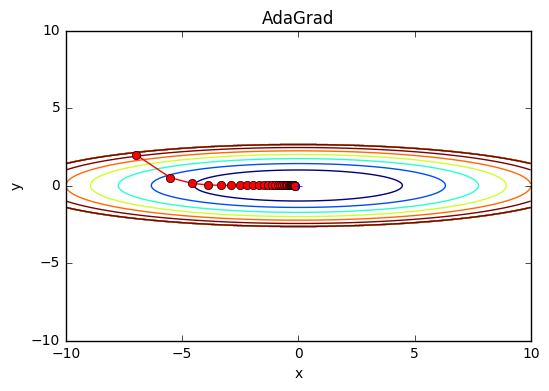

In [8]:
class AdaGrad:
    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            # h: 過去の勾配を2乗和して加算していく
            self.h[key] += grads[key] * grads[key]
            # 1/√hを乗算することで、パラメータの要素の中でよく動いた（大きく更新された）要素は、学習係数が小さくなる
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

# 等高線図上に描画
ContourPlotter().plot_contourmap(AdaGrad(lr=1.5), "AdaGrad")

## 6.1.6　Adam

Momentum（ボールがお椀を転がる物理法則）とAdaGrad（適応的に更新ステップを学習率で調整）を融合したような手法。
Momentumよりもボールの左右の揺れが軽減される。

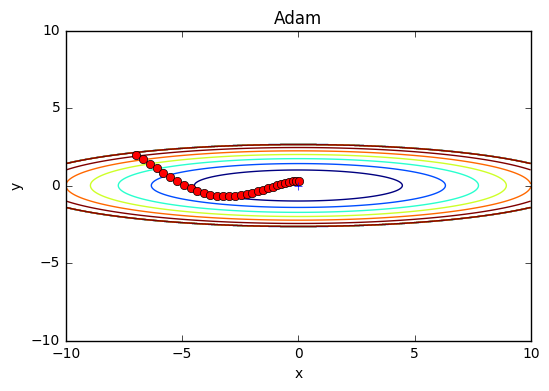

In [9]:
class Adam:
    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

# 等高線図上に描画
ContourPlotter().plot_contourmap(Adam(lr=0.3), "Adam")

## 6.1.7　どの更新手法を用いるか？

解くべき問題によって経路は変わる。

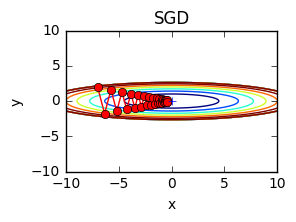

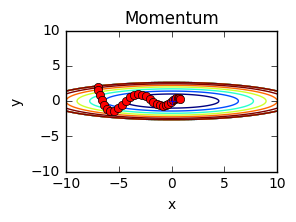

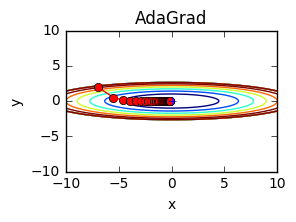

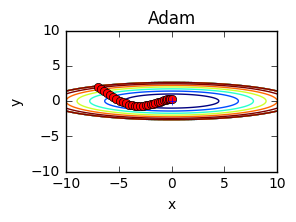

In [11]:
from collections import OrderedDict
 
optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

for i, key in enumerate(optimizers):
    optimizer = optimizers[key]
    plt.subplot(2, 2, i+1)
    ContourPlotter().plot_contourmap(optimizer, key)

# 比較のため、等高線図上に一括描画
plt.show()

## 6.1.8　MNISTデータセットによる更新手法の比較

MNISTの場合、 AdaGrad > Adam > Momentum >>>越えられない壁>>> SGD となる。

Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!
===========iteration:0===========
SGD:2.33290085822
Adam:2.1812232303
Momentum:2.3650568841
AdaGrad:2.30858946356
===========iteration:100===========
SGD:1.61224628367
Adam:0.33207622584
Momentum:0.391714181787
AdaGrad:0.167657570933
===========iteration:200===========
SGD:0.938598155772
Adam:0.225278792328
Momentum:0.336946190419
AdaGrad:0.154625615888
===========iteration:300===========
SGD:0.488423397074
Adam:0.0653278175885
Momentum:0.160582160995
AdaGrad:0.0492946166726
===========iteration:400===========
SGD:0.573807157142
Adam:0.174099390695
Momentum:0.324573688599
AdaGrad:0.131171258445
===========iteration:500===========
SGD:0.336940230891
Adam:0.0761596046151
Momentum:0.0905327153371
AdaGrad:0.0749580995

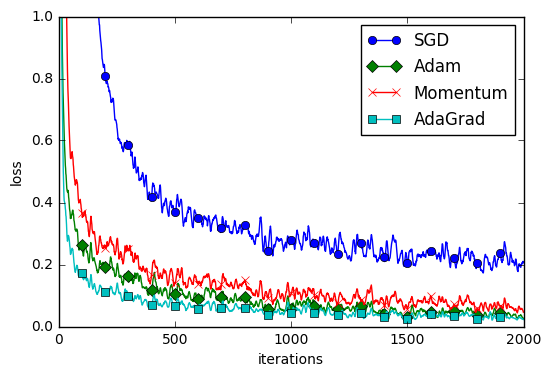

In [12]:
# coding: utf-8
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet

# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

## 6.1の参考情報

### 動きの比較

[勾配降下法の最適化アルゴリズムを概観する](http://postd.cc/optimizing-gradient-descent/) より

<img src="https://qiita-image-store.s3.amazonaws.com/0/145675/7d6df135-32ae-1e6c-1a98-bee7b51ddcb0.gif" alt="等高線図" style="width:360px;display:inline;"/>
<img src="https://qiita-image-store.s3.amazonaws.com/0/145675/3ed59066-a2a1-dc2d-e63d-e0d902d04d54.gif" alt="3次元図" style="width:360px;display:inline;"/>

### AdamとEve

[Inside of Deep Learning （ディープラーニングの性能改善手法 一覧） - Qiita](http://qiita.com/jiny2001/items/1d3f2d0370b2689d2da7#%E5%90%84%E7%A8%AE%E3%82%AA%E3%83%97%E3%83%86%E3%82%A3%E3%83%9E%E3%82%A4%E3%82%B6-adam%E3%81%A8eve) より

> また、最近Eveという名前の新しいオプティマイザが考案されました。これはAdamの強化版で、論文を読んだ限りでは損失値の変化を見てやって、変化が大きい場合はより大きな学習係数を設定し変化が小さくなったらより小さな学習係数を設定する機能を追加したもののようです。これによりさらに性能が上がったとしています。イブというと僕は風邪薬を想起してしまいなかなか良く効きそうですが、Adamの上位版がEveというのはなかなか面白い名前だと思います。

元論文 [Improving Stochastic Gradient Descent with Feedback, Jayanth Koushik, Hiroaki Hayashi, 2016](https://arxiv.org/abs/1611.01505)

[ソースコード(GitHub)](https://github.com/jayanthkoushik/sgd-feedback)

[論文ソースコードのJupyter Notebookの実行結果](http://nbviewer.jupyter.org/github/jayanthkoushik/sgd-feedback/blob/master/src/compare_opts.ipynb)

## 6.2.1　重みの初期値を0にする？

重みの値はなるべく小さいほうが過学習が起きにくい。
それでは重みの初期値をすべて0にすればいいかというと、誤差逆伝播法で、すべての重みの値が均一に更新されてしまう（学習が起こらない）のでよくない。

## 6.2.2　隠れ層のアクティベーション分布

重みの初期値によって隠れ層のアクティベーション（活性化関数の後の出力データ）がどう変化するかを観察する。

In [65]:
# 実験のためのソースコード（隠れ層のアクティベーション分布を可視化）
class HiddenLayerActivation:
    def __init__(self):
        self.input_data = np.random.randn(1000, 100)  # 1000個のデータ
        self.node_num = 100  # 各隠れ層のノード（ニューロン）の数
        self.hidden_layer_size = 5  # 隠れ層が5層
    
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))

    def ReLU(self, x):
        return np.maximum(0, x)

    def tanh(self, x):
        return np.tanh(x)

    # ヒストグラムを描画する
    # 初期値の重み付け, 活性化関数を指定
    def plot_histograms(self, init_weight, z_function_name, xlim=(0.0, 1.0), ylim=(0, 7000)):
        x = self.input_data
        activations = {}  # ここにアクティベーションの結果を格納する
        z_function = { "sigmoid": self.sigmoid, "ReLU": self.ReLU, "tanh": self.tanh }[z_function_name]
        
        for i in range(self.hidden_layer_size):
            if i != 0:
                x = activations[i-1]
            w = np.random.randn(self.node_num, self.node_num) * init_weight # 初期値の値
            a = np.dot(x, w)
            z = z_function(a) # 活性化関数
            activations[i] = z

        # サイズ指定（横,縦)
        plt.figure(figsize=(10,2))
        
        # ヒストグラムを描画
        for i, a in activations.items():
            plt.subplot(1, len(activations), i+1)
            plt.title(str(i+1) + "-layer")
            if i != 0: plt.yticks([], [])
            plt.xlim(xlim)
            plt.ylim(ylim)
            plt.hist(a.flatten(), 30, range=(0,1))
        
        plt.show()

### 図6-10　重みの初期値として標準偏差1のガウス分布を用いたときの、各層のアクティベーションの分布

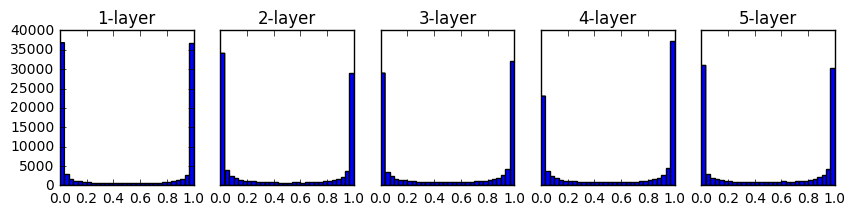

In [66]:
# 図6-10　重みの初期値として標準偏差1のガウス分布を用いたときの、各層のアクティベーションの分布
HiddenLayerActivation().plot_histograms(1.0, "sigmoid", ylim=(0, 40000))

0と1に偏った分布になるので、勾配消失（逆伝播で勾配の値がどんどん小さくなる）が起きやすい。

### 図6-11　重みの初期値として標準偏差0.01のガウス分布を用いたときの、各層のアクティベーションの分布

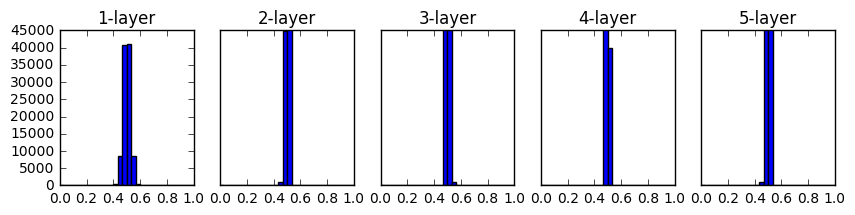

In [67]:
# 図6-11　重みの初期値として標準偏差0.01のガウス分布を用いたときの、各層のアクティベーションの分布
HiddenLayerActivation().plot_histograms(0.01, "sigmoid", ylim=(0, 45000))

今度は、0.5に偏りすぎる結果となった。勾配消失は起きないが、「表現力」（いろいろな値に分布できること）に乏しい。

### 図6-13　重みの初期値として「Xavierの初期値」を用いたときの、各層のアクティベーションの分布

前層のノードの個数をnとした場合、
$$
\frac{1}{\sqrt n}
$$
の標準偏差を持つ分布を使う

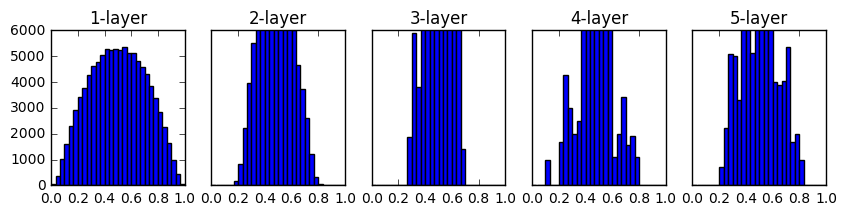

In [69]:
# 図6-13　重みの初期値として「Xavierの初期値」を用いたときの、各層のアクティベーションの分布
node_num = 100
HiddenLayerActivation().plot_histograms(1 / np.sqrt(node_num), "sigmoid", ylim=(0, 6000))

各層に流れるデータには適度な広がりがあるため、シグモイド関数の表現力も維持している。

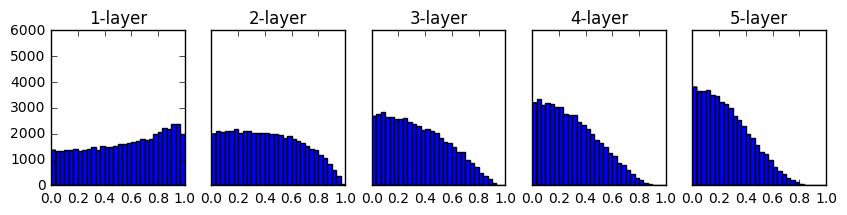

In [70]:
# tanhにした場合
HiddenLayerActivation().plot_histograms(1 / np.sqrt(node_num), "tanh", ylim=(0, 6000))

tanh関数の場合、原点(0, 0)で対称なS字カーブとなる。

## 6.2.3　ReLUの場合の重みの初期値

「Heの初期値」は、前層のノードの数がn個の場合、
$$
\sqrt{\frac{2}{n}}
$$
を標準偏差とするガウス分布を用いる。

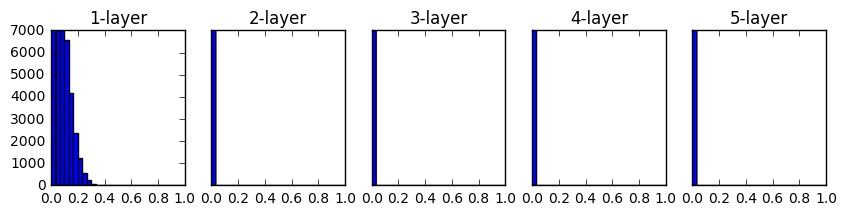

In [76]:
# 図6-14　活性化関数としてReLUを使用した場合の重みの初期値によるアクティベーション分布の変化
# 初期値0.01の場合
HiddenLayerActivation().plot_histograms(0.01, "ReLU")

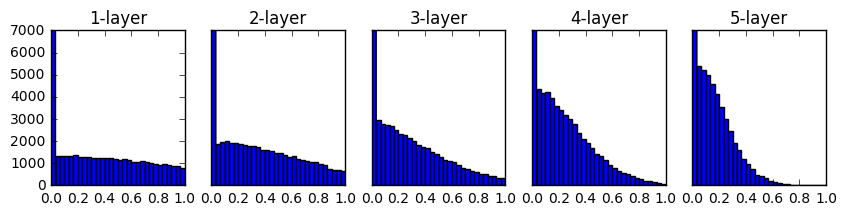

In [74]:
# 図6-14　活性化関数としてReLUを使用した場合の重みの初期値によるアクティベーション分布の変化
# 「Xavierの初期値」を用いた場合
node_num = 100
HiddenLayerActivation().plot_histograms(1 / np.sqrt(node_num), "ReLU")

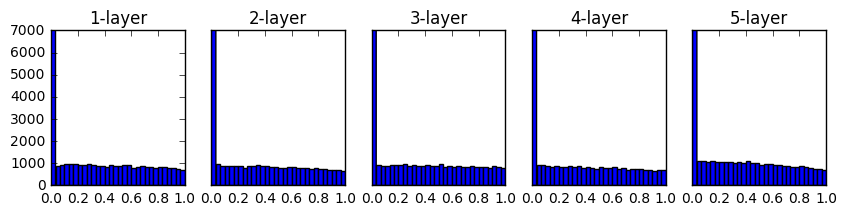

In [73]:
# 図6-14　活性化関数としてReLUを使用した場合の重みの初期値によるアクティベーション分布の変化
# 「Heの初期値」を用いた場合
node_num = 100
HiddenLayerActivation().plot_histograms(np.sqrt(2.0 / node_num), "ReLU")

In [ ]:
ReLU活性化関数で「Heの初期値」を用いた場合、各層で分布の広がりが均一になっているので、層を深めても偏りが生じない。

## 6.2.4　MNISTデータセットによる重み初期値の比較

===========iteration:0===========
Xavier:2.29956601794
He:2.30911704567
std=0.01:2.30252165591
===========iteration:100===========
Xavier:2.23788497948
He:1.63600911468
std=0.01:2.30335579652
===========iteration:200===========
Xavier:2.10520612729
He:0.802825495502
std=0.01:2.30345653259
===========iteration:300===========
Xavier:1.67500323774
He:0.45079637532
std=0.01:2.3022285408
===========iteration:400===========
Xavier:1.22400046809
He:0.483185233228
std=0.01:2.30146223553
===========iteration:500===========
Xavier:0.845894011603
He:0.375372252808
std=0.01:2.30457339336
===========iteration:600===========
Xavier:0.821635833349
He:0.505595123698
std=0.01:2.30255794401
===========iteration:700===========
Xavier:0.496376251996
He:0.309271572166
std=0.01:2.30012100587
===========iteration:800===========
Xavier:0.42944749131
He:0.240836696085
std=0.01:2.2983975897
===========iteration:900===========
Xavier:0.362983135933
He:0.20700672814
std=0.01:2.29822879551
===========iteration:100

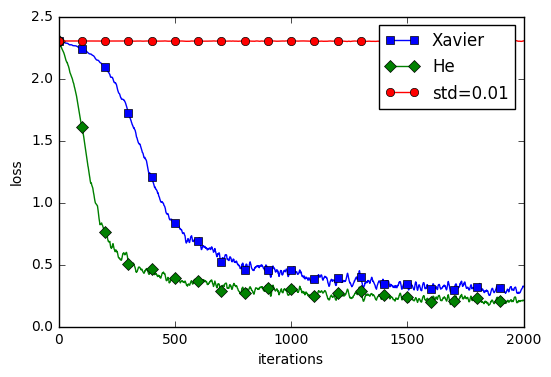

In [19]:
# coding: utf-8
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()